# **Assignment 1** (Intro to Machine Learning)

## Note:

* The dataset to be used is `attrition.csv`. This dataset reveals whether a particular employee left the company or not.  
* In this dataset, the column named `Attrition` is the target variable and the remaining columns are features. Please note that `Attrition = 1` means the employee left the company, whereas `Attrition = 0` means the opposite of this statement. 
*  This dataset has been loaded in this assignment as shown below. In case, you are not able to load this data, please note that this data is stored separately as well in the assignment folder. 

## Importing the data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
data_url = "https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L1/attrition.csv"
attrition_data = pd.read_csv(data_url)

In [3]:
attrition_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,ID
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,0,8,0,1,6,4,0,5,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,1,10,3,3,10,7,1,7,1
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,0,7,3,3,0,0,0,0,2
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,0,8,3,3,8,7,3,0,3
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,1,6,3,3,2,2,2,2,4


## Exploratory analysis of Data

In [4]:
attrition_data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'ID'],
      dtype='object')

In [5]:
attrition_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1028 non-null   int64 
 1   Attrition                 1028 non-null   int64 
 2   BusinessTravel            1028 non-null   object
 3   DailyRate                 1028 non-null   int64 
 4   Department                1028 non-null   object
 5   DistanceFromHome          1028 non-null   int64 
 6   Education                 1028 non-null   int64 
 7   EducationField            1028 non-null   object
 8   EmployeeCount             1028 non-null   int64 
 9   EmployeeNumber            1028 non-null   int64 
 10  EnvironmentSatisfaction   1028 non-null   int64 
 11  Gender                    1028 non-null   object
 12  HourlyRate                1028 non-null   int64 
 13  JobInvolvement            1028 non-null   int64 
 14  JobLevel                

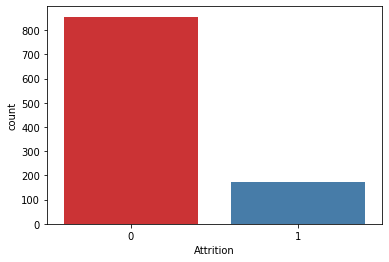

In [6]:
#Seeing the attrition rate in a plot
sns.countplot(attrition_data['Attrition'], palette='Set1')
plt.show()

In [7]:
#Converting Overtime data to binary
attrition_data['OverTime'] = attrition_data['OverTime'].apply(lambda x: 1 if(x=='Yes') else 0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D39FE5CD48>,
      dtype=object)

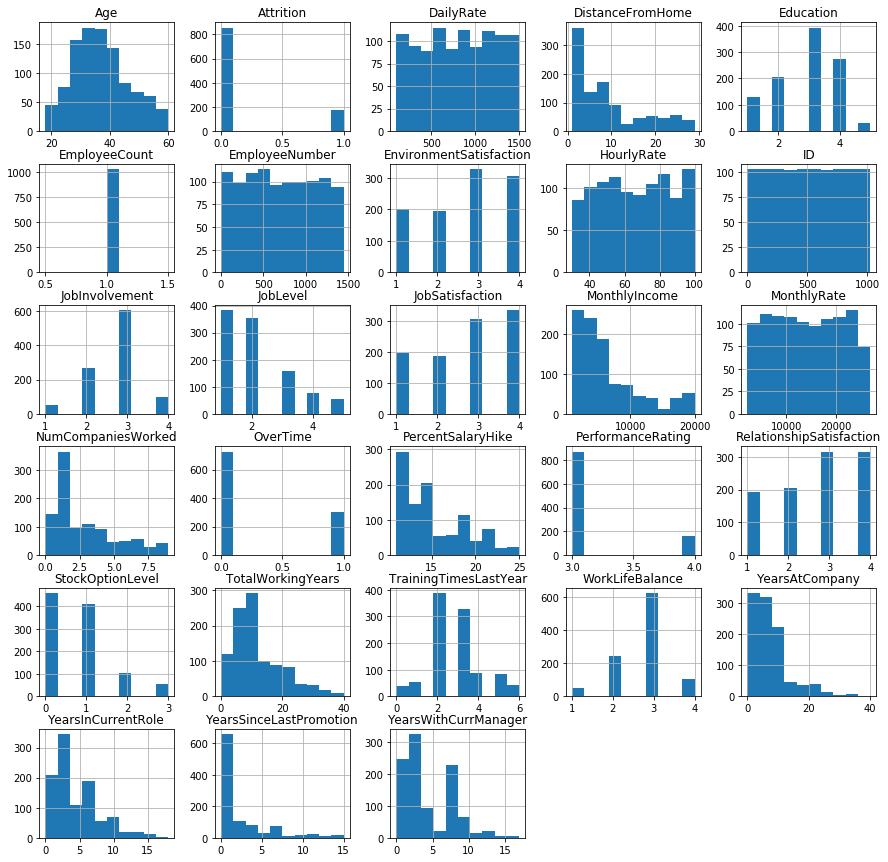

In [8]:
attrition_data.hist(figsize=(15, 15))

In [9]:
#Dropping data that will not be useful
attrition_data.drop(['ID', 'EmployeeNumber', 'EmployeeCount'], axis =1, inplace = True)

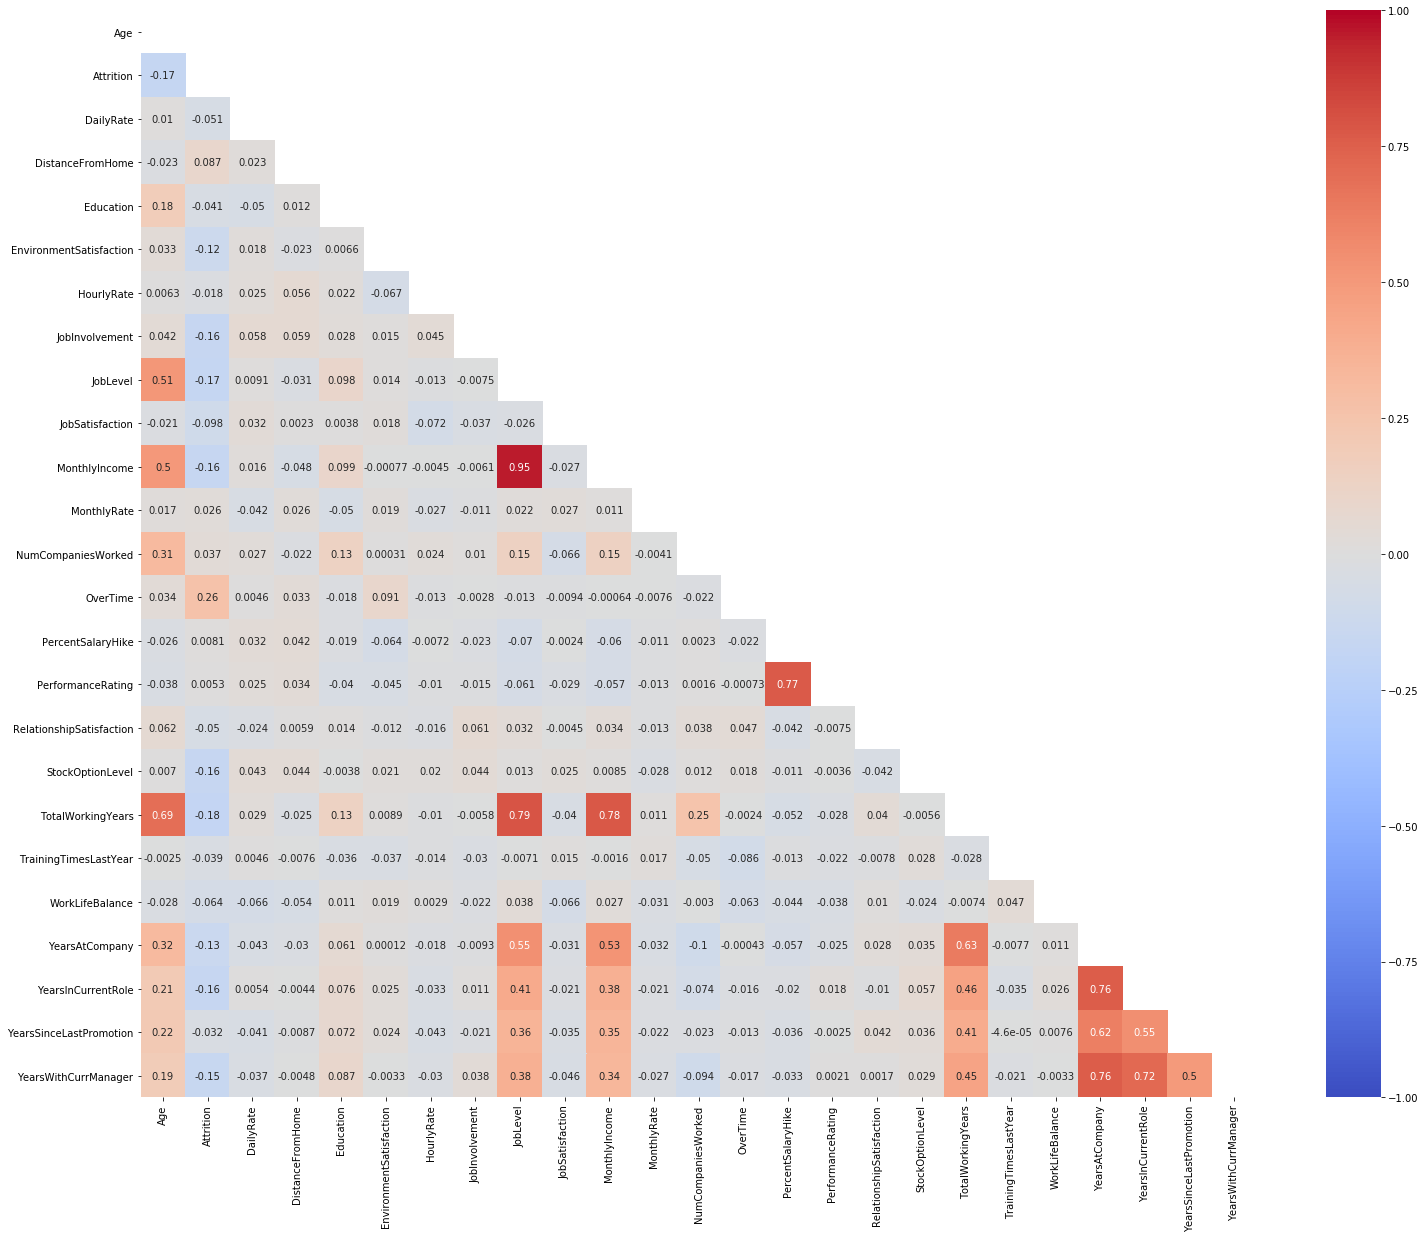

In [10]:
#Seeing the correlation matrix for this data
plt.figure(figsize=(25,20))
mask = np.zeros_like(attrition_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(attrition_data.corr(), 
            vmin = -1,
            cmap='coolwarm',
            annot=True,
            mask=mask)
plt.savefig('corr-matrix.png')
plt.show()

We see a high correlation between Monthly Income and Job Level (as expected), so one might consider dropping one of these.

In [11]:
object_cols = []
for i in attrition_data.columns:
    if(attrition_data.dtypes[i] == 'object'):
        print(attrition_data[i].value_counts())
        print()
        object_cols.append(i)

Travel_Rarely        729
Travel_Frequently    197
Non-Travel           102
Name: BusinessTravel, dtype: int64

Research & Development    683
Sales                     309
Human Resources            36
Name: Department, dtype: int64

Life Sciences       427
Medical             320
Marketing           119
Technical Degree     90
Other                57
Human Resources      15
Name: EducationField, dtype: int64

Male      597
Female    431
Name: Gender, dtype: int64

Sales Executive              223
Research Scientist           209
Laboratory Technician        183
Manufacturing Director       105
Healthcare Representative     85
Manager                       79
Research Director             59
Sales Representative          57
Human Resources               28
Name: JobRole, dtype: int64

Married     454
Single      342
Divorced    232
Name: MaritalStatus, dtype: int64



## Preprocessing the Data

In [12]:
X = attrition_data.drop('Attrition', axis = 1)
y = attrition_data['Attrition']


In [13]:
# Getting all the numerical columns
numerical_cols = []
for i in X.columns:
    if((attrition_data.dtypes[i] != 'object') and (i!='OverTime')):
        numerical_cols.append(i)

# Standardizing the numerical data
X[numerical_cols] = (X[numerical_cols] - X[numerical_cols].mean(axis=0))/X[numerical_cols].std(axis=0)

In [14]:
#One-hot encoding the object data
X = pd.get_dummies(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

## XGBClassifier

In [16]:
xgb = XGBClassifier(objective = 'binary:logistic', seed = 0)

In [17]:
kfold = StratifiedKFold(n_splits = 10)
results = cross_val_score(xgb, X_train, y_train, cv=kfold)
results.mean()

0.8467087863649722

Now, let us see how our model performs on the test set

In [18]:
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
accuracy_score(y_test, preds)

0.8737864077669902

In [19]:
print(confusion_matrix(y_test, preds))
print("="*60)
print(classification_report(y_test, preds))

[[171   6]
 [ 20   9]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       177
           1       0.60      0.31      0.41        29

    accuracy                           0.87       206
   macro avg       0.75      0.64      0.67       206
weighted avg       0.85      0.87      0.86       206



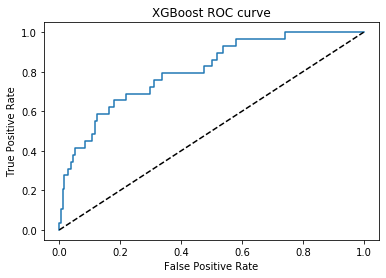

0.6382232612507305


In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
probs = xgb.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve')
# show the plot
plt.show()
print(roc_auc_score(y_test, preds))

In [21]:
parameters = {'max_depth' : range(1, 5, 1), 'n_estimators' : range(80, 150, 10), 'learning_rate' : [0.1, 0.05]}

grid_search = GridSearchCV(estimator = xgb, param_grid = parameters, scoring = 'roc_auc', cv = 10, verbose = True, n_jobs = 4)

In [22]:
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:   48.4s finished


({'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 140},
 0.8158364689159245)

In [23]:
new_xgb = grid_search.best_estimator_
new_xgb.fit(X_train, y_train)
preds = new_xgb.predict(X_test)
accuracy_score(y_test, preds)

0.883495145631068

In [24]:
print(confusion_matrix(y_test, preds))
print("="*60)
print(classification_report(y_test, preds))

[[175   2]
 [ 22   7]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       177
           1       0.78      0.24      0.37        29

    accuracy                           0.88       206
   macro avg       0.83      0.62      0.65       206
weighted avg       0.87      0.88      0.86       206



We can see that this classifier performs better than the previous one

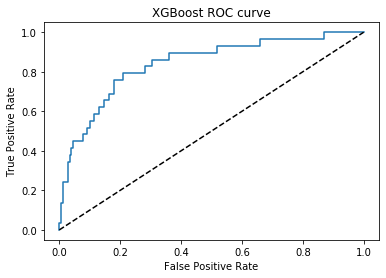

0.6150399376582895


In [25]:
probs = new_xgb.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve')
# show the plot
plt.show()
print(roc_auc_score(y_test, preds))

## Random Forest Classifier

In [26]:
rfc = RandomForestClassifier(random_state = 0)
kfold = StratifiedKFold(n_splits = 10)
results = cross_val_score(rfc, X_train, y_train, cv=kfold)
results.mean()

0.834528357331766

In [27]:
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
accuracy_score(y_test, preds)

0.8737864077669902

In [28]:
print(confusion_matrix(y_test, preds))
print("="*60)
print(classification_report(y_test, preds))

[[175   2]
 [ 24   5]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       177
           1       0.71      0.17      0.28        29

    accuracy                           0.87       206
   macro avg       0.80      0.58      0.60       206
weighted avg       0.86      0.87      0.84       206



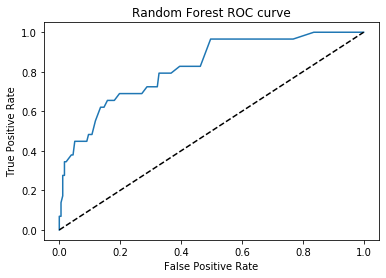

0.5805571790376


In [29]:
probs = rfc.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
# show the plot
plt.show()
print(roc_auc_score(y_test, preds))

In [30]:
parameters = {'max_depth' : range(2, 10, 1), 'n_estimators' : range(50, 250, 40), 'min_samples_split' : range(2, 5, 1)}

grid_search = GridSearchCV(estimator = rfc, param_grid = parameters, scoring = 'roc_auc', cv = 10, verbose = True, n_jobs = 10)

In [31]:
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   20.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   46.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 1200 out of 1200 | elapsed:  2.3min finished


({'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 210},
 0.807803315355993)

In [32]:
new_rfc = grid_search.best_estimator_
new_rfc.fit(X_train, y_train)
preds = new_rfc.predict(X_test)
accuracy_score(y_test, preds)

0.8786407766990292

In [33]:
print(confusion_matrix(y_test, preds))
print("="*60)
print(classification_report(y_test, preds))

[[176   1]
 [ 24   5]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       177
           1       0.83      0.17      0.29        29

    accuracy                           0.88       206
   macro avg       0.86      0.58      0.61       206
weighted avg       0.87      0.88      0.84       206



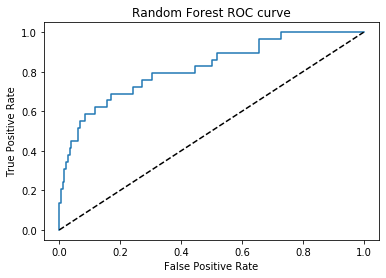

0.583382037794662


In [34]:
probs = new_rfc.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
# show the plot
plt.show()
print(roc_auc_score(y_test, preds))

## KNeighbours Classifier

In [35]:
knc = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits = 10)
results = cross_val_score(knc, X_train, y_train, cv=kfold)
results.mean()

0.8224066999706141

In [36]:
knc.fit(X_train, y_train)
preds = knc.predict(X_test)
accuracy_score(y_test, preds)

0.8737864077669902

In [37]:
print(confusion_matrix(y_test, preds))
print("="*60)
print(classification_report(y_test, preds))

[[175   2]
 [ 24   5]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       177
           1       0.71      0.17      0.28        29

    accuracy                           0.87       206
   macro avg       0.80      0.58      0.60       206
weighted avg       0.86      0.87      0.84       206



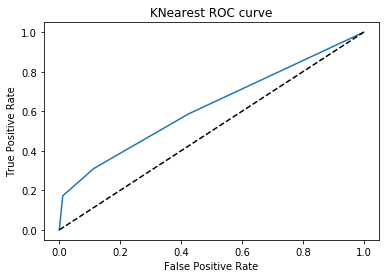

0.5805571790376


In [38]:
probs = knc.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNearest ROC curve')
# show the plot
plt.show()
print(roc_auc_score(y_test, preds))

In [39]:
parameters = {'leaf_size' : range(10, 80, 5)}

grid_search = GridSearchCV(estimator = knc, param_grid = parameters, scoring = 'roc_auc', cv = 10, verbose = True, n_jobs = 4)

In [40]:
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    4.1s finished


({'leaf_size': 10}, 0.6543408482796103)

In [41]:
new_knc = grid_search.best_estimator_
new_knc.fit(X_train, y_train)
preds = new_knc.predict(X_test)
accuracy_score(y_test, preds)

0.8737864077669902

In [42]:
print(confusion_matrix(y_test, preds))
print("="*60)
print(classification_report(y_test, preds))

[[175   2]
 [ 24   5]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       177
           1       0.71      0.17      0.28        29

    accuracy                           0.87       206
   macro avg       0.80      0.58      0.60       206
weighted avg       0.86      0.87      0.84       206



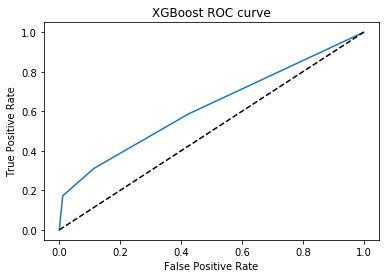

0.5805571790376


In [43]:
probs = new_knc.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve')
# show the plot
plt.show()
print(roc_auc_score(y_test, preds))

## Inferences

The XGBClassifier works best among the methods employed, but only by a very small fraction. All the methods perform more or less the same for the data.

## Instructions:

* You are required to use a classifier, which can predict the `Attrition` for the employees. 
* Before implementing any model, you will have to apply suitable encoding to the features and implement exploratory data analysis to know your data better. 
* You can either define your own custom-made classifer or select classifier(s) available in the `scikit-learn`.
* You are supposed to implement a minimum of three classifiers (e.g.  `RandomForestClassifier`, `XGBClassifier`, `DecisionTreeClassifier`, `KNeighborsClassifier`, etc.) and evaluate which one is giving the best peformance. 
* For each of the classifier,  report the accuracy, precision, recall, roc curve, etc. 

## Resources:

* You might want to refer to the [lecture notebook](https://github.com/shala2020/shala2020.github.io/tree/master/Lecture_Materials/Google_Colab_Notebooks/MachineLearning/L1) for revising the concepts.
* You can also refer to the pre-work material for the first lecture on ML.  